# Testing Environment for Time Domain Response of Eurus
Shaun Hadden & Brendan Smithyman | October, 2015

## Imports

In [1]:
import sys
sys.path.append('../')
import numpy as np
from zephyr.backend import Eurus, StackedSimpleSource, KaiserSource, AnisotropicKaiserSource, MultiFreq

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import matplotlib.animation as animation
import math
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
matplotlib.rcParams['savefig.dpi'] = 150 # Change this to adjust figure size

## Helper functions

In [3]:
class Source(object):
    
    def __init__(self, sc):
                
        self._x, self._z = np.mgrid[
            0:sc['dx']*sc['nx']:sc['dx'],
            0:sc['dz']*sc['nz']:sc['dz']
        ]
    
    def __call__(self, x, z):
        
        dist = np.sqrt((self._x - x)**2 + (self._z - z)**2)
        srcterm = 1.*(dist == dist.min())
        nz, nx = self._x.shape
        
        return np.hstack([srcterm.T.ravel() / srcterm.sum(), np.zeros(nx*nz, dtype=np.complex128)])

## Modelling setup

In [4]:
# Geometry parameters
dx          = 5.
dz          = 5.
nx          = 50
nz          = 50

# Bulk parameters
velReal     = 1000.     * np.ones((nz,nx))
density     = 1.        * np.ones((nz,nx))

Q           = np.inf
velImag     = ((-1 * velReal) * 2)/Q

velocity    = velReal + (1j * velImag)
# Anisotropy parameters
theta       = 0        * np.ones((nz,nx))
epsilon     = 0.1        * np.ones((nz,nx))
delta       = 0.2      * np.ones((nz,nx))

# Other parameters
freq        = 4.
freeSurf    = [False, False, False, False]
nPML        = 5
fDamp       = 0.4

# Source and Modelling Parameters 
sourceFreq = 32.


#   determine the maximum length of the Model
xMax = (nx-1) * dx
zMax = (nz-1) * dz
LMax = np.max([xMax,zMax])

#calculate the lowest velocity
cMin = velocity.min()

#calculate the smallest wavelength, in meters
#lambdaMin = cMin / fMax

#   Set the sampling interval and number of time domain samples

dt = 0.002
nTSamp = 256
#nt = tMax / dt

#   Set the maximum modelled time and the damping factor
tMax = dt * nTSamp
tau = fDamp * tMax

#   determine the frequency interval, max frequency and frequency range from the maximum modelled time

df= 1 / tMax
fMax = 1 / dt
nf = int(fMax / df)
fMin = fMax - ((nf - 1) * df)
freqRange = np.arange(fMin,fMax + df,df)

# Pack values into systemConfig dictionary
systemConfig = {
    'nx':       nx,
    'nz':       nz,
    'dx':       dx,
    'dz':       dz,

    'c':        velocity,
    'rho':      density,
    
    'theta':    theta,
    'eps':      epsilon,
    'delta':    delta,

    'freq':     freqRange[0],
    'freqs':    freqRange,
    'freeSurf': freeSurf,
    'nPML':     nPML,
    'cPML':     1e3,
    
    'tau':      tau,
    'f_max':    fMax, 
    'source_freq': sourceFreq,
    'nt':       nTSamp,
    'nf':       nf,
    'df':       df,
    'nf':       nf,
    'disc':     Eurus,             # discretization
    'parallel': True,
}

## Generate A Source Wavelet

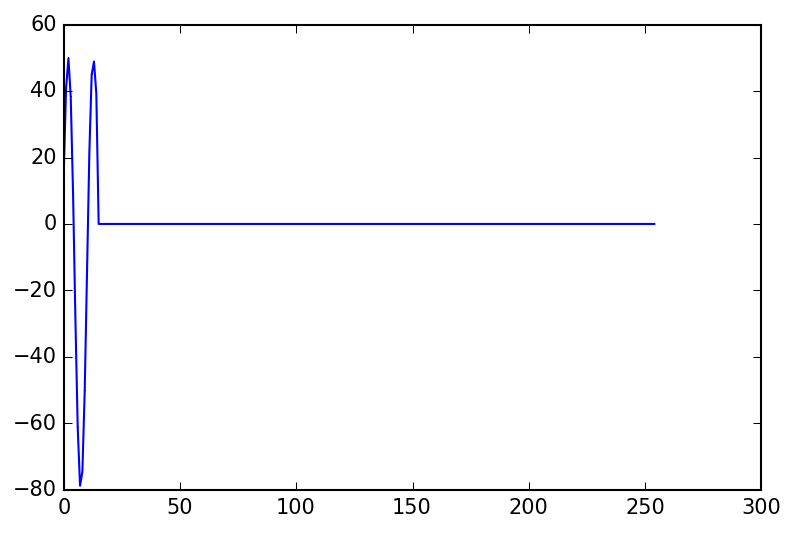

In [5]:
#keuper wavelet
excursions=1
m = (excursions + 2) / excursions
nsrc = int((1. / sourceFreq) / dt)
delta = excursions * np.pi * sourceFreq
tsrc = np.zeros(nsrc)
tempSource = np.zeros(nsrc)

for i in range(1,nsrc+1):

    tsrc[i-1] = (i - 1.) * dt
    tempSource[i-1] = (delta * np.cos(delta *tsrc[i-1])) - (delta *np.cos(m * delta *tsrc[i-1]))
            
timeSource = np.zeros(nTSamp)
timeSource[:len(tempSource)] = tempSource[:]

# plot the source
plt.plot(np.diff(timeSource), markersize=0.1, marker=',')

# perform forward fft to generate frequency domain source wavefields

freqSource=np.fft.fft(np.asarray(timeSource))
freqSource[-((nTSamp / 2) + 1):]=0

#plt.plot(abs(freqSource), markersize=0.1, marker=',')

## Wavefield Inversion

In [6]:
uP = np.zeros((nf,nz,nx),dtype=np.complex128)
#Ainv =  Eurus(systemConfig)


for i in range(1,len(freqRange)):
    
    #if (freqRange[i-1] <= sourceFreq):
    if (freqRange[i-1] <= (sourceFreq * 4.)):
        systemConfig['freq'] = freqRange[i-1]
        Ainv =  Eurus(systemConfig)
        src = StackedSimpleSource(systemConfig)
        #src = AnisotropicKaiserSource(systemConfig)
        #src = AnisotropicKaiserSource(systemConfig)
        q = src(np.array([[125,125]]))
        uP[i-1] = (Ainv* (q * (-1 * freqSource[i])))[:nx*nz].reshape((nz,nx))
    else:
        break


In [7]:
#Convert frequency domain wavefields to time domain using ifft

tempFreq = np.zeros((nTSamp,nz,nx),dtype=np.complex128)
istart   = 1
iend   = math.ceil(nTSamp/2)+1
tempFreq[istart:iend] = uP[:iend-1]
tempFreq[iend:] =np.flipud(uP[:iend-2]).conjugate()
#tempFreq[iend+1:nTSamp+2,:,:] =0
uT = np.zeros((nTSamp,nz,nx),dtype=np.complex128)   
uT = np.fft.ifft(tempFreq.conjugate(),axis=0)

/Users/brendan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/brendan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<matplotlib.colorbar.Colorbar instance at 0x10951cd40>

/Users/brendan/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


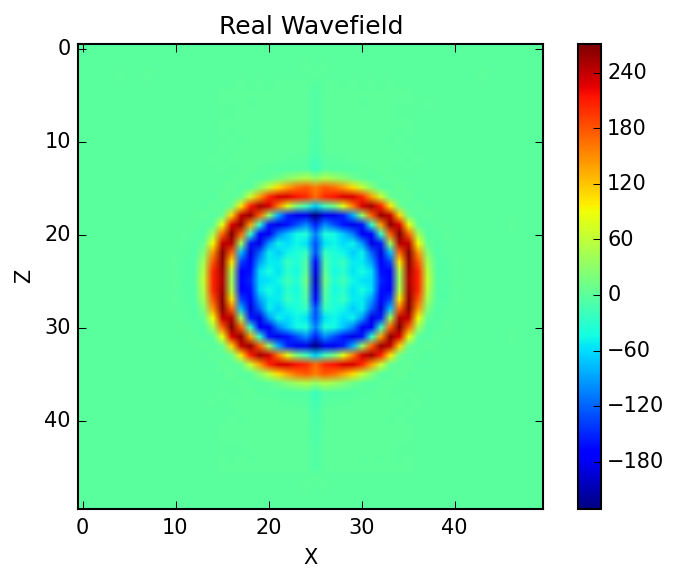

In [8]:

clip = 0.1

plotopts = {
    'extent':   [0, nx*dx, nz*dz, 0],
    'cmap':     cm.bwr,
    'vmin':     -clip,
    'vmax':     clip,
}
plt.imshow(uT[30].reshape((nz,nx)).real)
#plt.imshow(np.angle(uT[10].reshape((nz,nx))), **plotopts)
#plt.imshow(uT[5].reshape((nz,nx)).real)
#plt.imshow(uT[120,40:60,40:60].reshape((20,20)).real)
plt.title('Real Wavefield')
plt.xlabel('X')
plt.ylabel('Z')
plt.colorbar()

In [9]:
#plt.figure()
#plt.plot(uT[20].reshape((nz,nx)).real[:,50])

<matplotlib.colorbar.Colorbar instance at 0x1091c09e0>

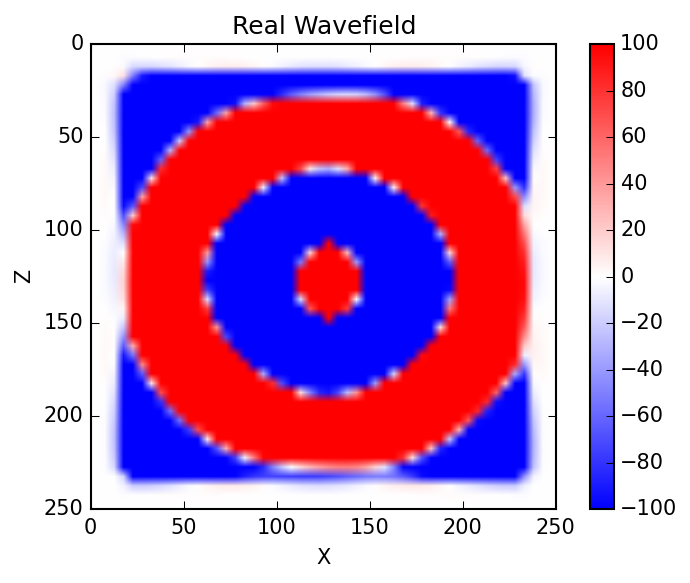

In [10]:
fig = plt.figure()
clip = 10e1
#fig  = plt.figure()
#ax = fig.add_subplot(1,1,1, aspect=1)
plotopts = {
    'extent':   [0, nx*dx, nz*dz, 0],
    'cmap':     cm.bwr,
    'vmin':     -clip,
    'vmax':     clip,
    }
ax = fig.add_subplot(1,1,1, aspect=1)
#plt.imshow(abs(uP[5].reshape((nz,nx))), **plotopts)
plt.imshow((uP[5].real.reshape((nz,nx))), **plotopts)
plt.title('Real Wavefield')
plt.xlabel('X')
plt.ylabel('Z')
plt.colorbar()

In [11]:
#clip = 2e-2
#fig  = plt.figure()
#ax = fig.add_subplot(1,1,1, aspect=1)
#plotopts = {
#    'extent':   [0, nx*dx, nz*dz, 0],
#    'cmap':     cm.bwr,
#    'vmin':     -clip,
#    'vmax':     clip,
#}
#im   = plt.imshow(uT[0].reshape((nz,nx)).real, **plotopts)
#im   = plt.imshow(uT[0].reshape((nz,nx)).real)

#def updatefig(j):
    
#   im.set_array(uT[j].reshape((nz,nx)).real)
#   return im,

#ani = animation.FuncAnimation(fig, updatefig)
#fig = plt.figure(figsize=(8,6), dpi=160)
#ani.save()

#plt.imshow(uT[200].reshape((nz,nx)).real, **plotopts)
#plt.title('Real Wavefield')
#plt.xlabel('X')
#plt.ylabel('Z')
#plt.show()

In [12]:
print nf
print df
print fMax
print sourceFreq
print dt

256
1.953125
500.0
32.0
0.002


In [13]:
wx = (1. + (2*epsilon) +np.sqrt(1+(2*delta)))/(1 + epsilon + np.sqrt(1+(2*delta)))
wz = (1.  + np.sqrt(1+(2*delta)))/(1 + epsilon + np.sqrt(1+(2*delta)))

print wx.min()
print wz.min()

1.00652961061
0.99347038939


In [14]:
print Ainv.K
print Ainv.Kavg

AttributeError: 'Eurus' object has no attribute 'K'